In [1]:
import copy
import logging
import math
import pandas
from matplotlib import pyplot as plt
from py_ballisticcalc import TableG7, TableG1
from py_ballisticcalc import Ammo, Atmo, Wind
from py_ballisticcalc import Weapon, Shot, Calculator
from py_ballisticcalc import PreferredUnits
from py_ballisticcalc.drag_model import *
from py_ballisticcalc.unit import *
from py_ballisticcalc.trajectory_calc import *
from py_ballisticcalc.logger import logger

logger.setLevel(logging.WARNING)
print("Default units:\n"+str(PreferredUnits))  # Print default units

Default units:
angular = degree
distance = yard
velocity = fps
pressure = inHg
temperature = fahrenheit
diameter = inch
length = inch
weight = grain
adjustment = mil
drop = inch
energy = foot-pound
ogw = pound
sight_height = inch
target_height = inch
twist = inch


d:\Code\py-ballisticcalc\py_ballisticcalc\__init__.py:44: UserWarning: Library running in pure python mode. For better performance install 'py_ballisticcalc.exts' binary package
  warnings.warn("Library running in pure python mode. "


# Simple Zero

In [2]:
# Establish 100-yard zero for a standard .308, G7 BC=0.22, muzzle velocity 2600fps
zero = Shot(weapon=Weapon(sight_height=Distance.Inch(2)), ammo=Ammo(DragModel(0.22, TableG7), mv=Velocity.FPS(2600)))
calc = Calculator()
zero_distance = Distance.Yard(100)
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << PreferredUnits.adjustment}')

Barrel elevation for 100.0yd zero: 1.335mil


# Plot Trajectory with Danger Space

Danger space at 300.0yd for 19.7inch tall target ranges from 217.0yd to 356.0yd


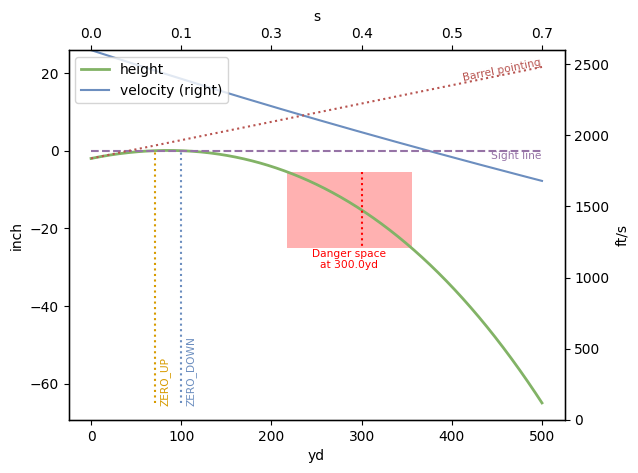

In [3]:
# Plot trajectory out to 500 yards
shot_result = calc.fire(zero, trajectory_range=Distance.Yard(500),
                        trajectory_step=Distance.Yard(1), extra_data=True)
ax = shot_result.plot()
# Find danger space for a half-meter tall target at 300 yards
danger_space = shot_result.danger_space(Distance.Yard(300), Distance.Meter(.5))
print(danger_space)
danger_space.overlay(ax)  # Highlight danger space on the plot
plt.show()

# Print Range Card

In [4]:
# Range card for this zero with 5mph cross-wind from left to right
zero.winds = [Wind(Velocity.MPH(5), Angular.OClock(3))]
range_card = calc.fire(zero, trajectory_range=1000)
# for p in range_card: print(p.formatted())
range_card.dataframe().to_clipboard()
range_card.dataframe(True).drop(['height', 'look_distance', 'density_factor', 'energy', 'ogw', 'flag'], axis=1).set_index('distance')

,time,velocity,mach,target_drop,drop_adj,windage,windage_adj,angle,drag
distance,,,,,,,,,
0.0 yd,0.000 s,2600.0 ft/s,2.33 mach,-2.0 inch,0.000 mil,0.0 inch,0.000 mil,0.0751 °,0.000
100.0 yd,0.120 s,2398.1 ft/s,2.15 mach,0.0 inch,0.000 mil,0.4 inch,0.119 mil,-0.0137 °,0.658
200.0 yd,0.251 s,2205.4 ft/s,1.98 mach,-4.1 inch,-0.574 mil,1.7 inch,0.247 mil,-0.1183 °,0.626
300.0 yd,0.393 s,2022.3 ft/s,1.81 mach,-15.3 inch,-1.441 mil,4.1 inch,0.386 mil,-0.2424 °,0.596
400.0 yd,0.548 s,1847.5 ft/s,1.65 mach,-35.0 inch,-2.478 mil,7.6 inch,0.538 mil,-0.3906 °,0.570
500.0 yd,0.718 s,1680.0 ft/s,1.50 mach,-65.0 inch,-3.678 mil,12.4 inch,0.703 mil,-0.5689 °,0.547
600.0 yd,0.906 s,1519.4 ft/s,1.36 mach,-107.3 inch,-5.062 mil,18.8 inch,0.887 mil,-0.7857 °,0.524
700.0 yd,1.114 s,1365.9 ft/s,1.22 mach,-164.8 inch,-6.661 mil,27.0 inch,1.090 mil,-1.0524 °,0.499
800.0 yd,1.347 s,1221.2 ft/s,1.09 mach,-241.0 inch,-8.523 mil,37.3 inch,1.318 mil,-1.3844 °,0.465


# Firing Solutions

## Different Distance, from Range Card

First approach here shows getting firing solution by looking up the adjustment in the Range Card:

In [5]:
# Now shooter is sighting a target at look-distance 500 yard (zero.look-angle):
new_target_distance = Distance.Yard(500)
# Get row for this distance from the range card
new_target = range_card.get_at_distance(new_target_distance)
print(f'Zero trajectory hits {new_target.target_drop << PreferredUnits.drop}'
      f' at {(new_target.distance << PreferredUnits.distance)}')

# Shooter looks up adjustment to hit new target:
hold = new_target.drop_adj  # << Firing solution

print(f'Sight adjustment to hit {(new_target.distance << PreferredUnits.distance)} target'
      f' is {(hold << PreferredUnits.adjustment)}')
# Shooter dials that hold value for a 500-yard shot.  Verification:
range_card.shot.relative_angle = Angular(-hold.unit_value, hold.units)
adjusted_result = calc.fire(range_card.shot, trajectory_range=1000)
trajectory_adjusted = adjusted_result.get_at_distance(new_target_distance)
print(f'After adjustment: drop at {trajectory_adjusted.distance << PreferredUnits.distance}'
      f' is {trajectory_adjusted.target_drop << PreferredUnits.drop}')

Zero trajectory hits -65.0inch at 500.0yd
Sight adjustment to hit 500.0yd target is -3.678mil
After adjustment: drop at 500.0yd is -0.0inch


## Different Look Angle

Second approach here shows solving for barrel elevation to hit new target, then adjusting by the difference between that and the zero barrel elevation:

In [6]:
# Calculate elevation for a new shot at a different look-angle
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(25.84)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))

print(f'To hit target at look-distance of {new_target_distance << PreferredUnits.distance}'
      f' sighted at a {new_shot.look_angle << PreferredUnits.angular} look-angle,' 
      f' barrel elevation={new_elevation << PreferredUnits.adjustment}')
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << PreferredUnits.adjustment}'
      f' so hold for new shot is {hold << PreferredUnits.adjustment}')      
horizontal = Distance(math.cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'(Horizontal component of distance to this target is {horizontal})')

# Plot this shot
new_shot.relative_angle = hold
card = calc.fire(new_shot, trajectory_range=500)
card.dataframe(True).drop(['height', 'energy', 'ogw', 'drag', 'flag'], axis=1).set_index('distance')

To hit target at look-distance of 500.0yd sighted at a 25.84° look-angle, barrel elevation=4.416mil
Current zero has barrel elevated 1.335mil so hold for new shot is 3.081mil
(Horizontal component of distance to this target is 450.0yd)


,time,velocity,mach,target_drop,drop_adj,windage,windage_adj,look_distance,angle,density_factor
distance,,,,,,,,,,
0.0 yd,0.000 s,2600.0 ft/s,2.33 mach,-1.8 inch,0.000 mil,0.0 inch,0.000 mil,0.0 yd,26.0884 °,2.173e-05
50.0 yd,0.066 s,2485.7 ft/s,2.23 mach,6.1 inch,3.127 mil,0.1 inch,0.072 mil,55.6 yd,26.0456 °,-2.119e-03
100.0 yd,0.134 s,2374.5 ft/s,2.13 mach,12.5 inch,3.186 mil,0.5 inch,0.148 mil,111.1 yd,25.9987 °,-4.257e-03
150.0 yd,0.206 s,2266.4 ft/s,2.03 mach,17.2 inch,2.914 mil,1.2 inch,0.226 mil,166.7 yd,25.9473 °,-6.389e-03
200.0 yd,0.282 s,2161.5 ft/s,1.94 mach,20.0 inch,2.539 mil,2.2 inch,0.308 mil,222.2 yd,25.8909 °,-8.509e-03
250.0 yd,0.361 s,2059.7 ft/s,1.85 mach,20.7 inch,2.104 mil,3.5 inch,0.394 mil,277.8 yd,25.8287 °,-1.062e-02
300.0 yd,0.444 s,1960.8 ft/s,1.76 mach,19.1 inch,1.621 mil,5.1 inch,0.483 mil,333.3 yd,25.7603 °,-1.272e-02
350.0 yd,0.531 s,1864.5 ft/s,1.67 mach,15.0 inch,1.093 mil,7.1 inch,0.576 mil,388.9 yd,25.6846 °,-1.481e-02
400.0 yd,0.622 s,1770.7 ft/s,1.59 mach,8.2 inch,0.520 mil,9.5 inch,0.675 mil,444.4 yd,25.6008 °,-1.690e-02


# Complex example

Now we'll switch to metric units and:
* Define a standard .50BMG
* Enable and define Ammo model of powder temperature sensitivity.
* Zeroed for a distance of 500 meters, in a 5°C atmosphere at altitude 1000ft ASL.

In [7]:
PreferredUnits.distance = Unit.Meter
PreferredUnits.velocity = Unit.MPS
PreferredUnits.drop = Unit.Meter
PreferredUnits.sight_height = Unit.Centimeter

# Standard .50BMG
dm = DragModel(0.62, TableG1, 661, 0.51, 2.3)
ammo=Ammo(dm, 850, Temperature.Celsius(15), use_powder_sensitivity=True)
ammo.calc_powder_sens(820, Temperature.Celsius(0))
weapon = Weapon(sight_height=9, twist=15)
atmo = Atmo(altitude=Distance.Foot(1000), temperature=Unit.Celsius(5), humidity=.5)
zero = Shot(weapon=weapon, ammo=ammo, atmo=atmo)
zero_distance = Distance.Meter(500)
calc = Calculator()
zero_elevation = calc.set_weapon_zero(zero, zero_distance)
print(f'Barrel elevation for {zero_distance} zero: {zero_elevation << PreferredUnits.adjustment}')
print(f'Muzzle velocity at zero temperature {atmo.temperature} is {ammo.get_velocity_for_temp(atmo.temperature) << PreferredUnits.velocity}')

Barrel elevation for 500.0m zero: 4.694mil
Muzzle velocity at zero temperature 41.0°F is 829.0m/s


To hit target at look-distance of 700.0m sighted at a 30.0° look-angle, barrel elevation=6.052mil
	(horizontal distance to this target is 606.2m)
Current zero has barrel elevated 4.694mil so hold for new shot is 1.359mil
Danger space at 701.0m for 4.0m tall target at 30.0° look-angle ranges from 463.0m to 823.0m


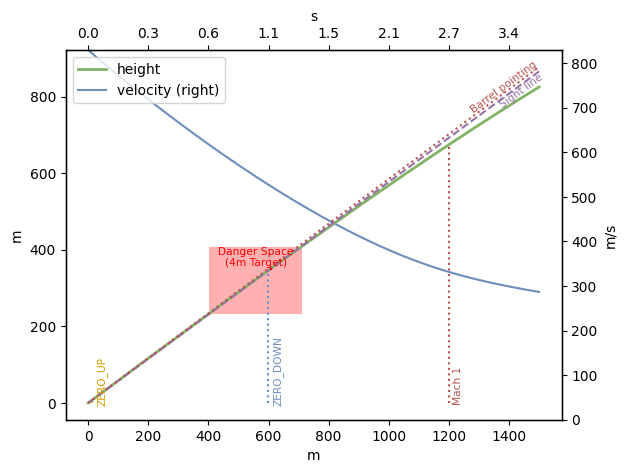

In [8]:
# Firing solution for 700m target at 30°
new_shot = copy.copy(zero)  # Copy the zero properties; NB: Not a deepcopy!
new_shot.look_angle = Angular.Degree(30)
new_target_distance = Distance.Meter(700)
new_elevation = calc.barrel_elevation_for_target(shot=new_shot, target_distance=new_target_distance)
horizontal = Distance(math.cos(new_shot.look_angle >> Angular.Radian)
                      * new_target_distance.unit_value, new_target_distance.units)
print(f'To hit target at look-distance of {new_target_distance << PreferredUnits.distance}'
      f' sighted at a {new_shot.look_angle << PreferredUnits.angular} look-angle,' 
      f' barrel elevation={new_elevation << PreferredUnits.adjustment}'
      f'\n\t(horizontal distance to this target is {horizontal})')

# Firing solution:
hold = Angular.Mil((new_elevation >> Angular.Mil) - (zero.weapon.zero_elevation >> Angular.Mil))
print(f'Current zero has barrel elevated {zero.weapon.zero_elevation << PreferredUnits.adjustment}'
      f' so hold for new shot is {hold << PreferredUnits.adjustment}')      

# Plot this shot
new_shot.relative_angle = hold
adjusted_result = calc.fire(new_shot, trajectory_range=Distance.Meter(1500),
                            trajectory_step=Distance.Meter(1), extra_data=True)
ax = adjusted_result.plot()
# Find danger space for a 4-meter tall target
danger_space = adjusted_result.danger_space(at_range=new_target_distance,
                                        target_height=Distance.Meter(4),
                                        look_angle=new_shot.look_angle)
print(danger_space)
# Highlight danger space on the plot
danger_space.overlay(ax, 'Danger Space\n(4m Target)')
plt.show()

## Multiple Winds

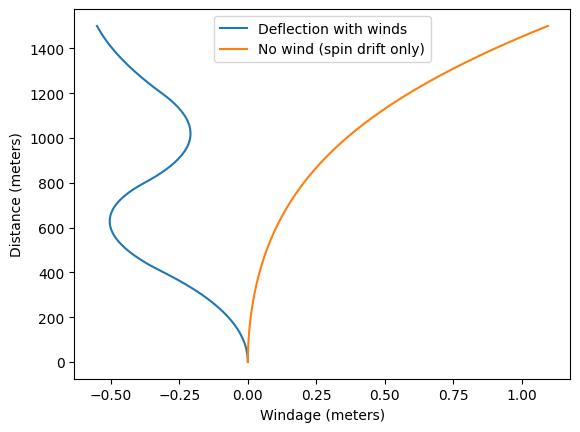

In [9]:
new_shot.winds = [Wind(Velocity.MPS(4), Angular.OClock(9), until_distance=Distance.Meter(400)),
                  Wind(Velocity.MPS(4), Angular.OClock(3), until_distance=Distance.Meter(800)),
                  Wind(Velocity.MPS(4), Angular.OClock(9), until_distance=Distance.Meter(1200)),]
wind_result = calc.fire(new_shot, trajectory_range=Distance.Meter(1500), trajectory_step=Distance.Meter(5), extra_data=True)
ax = wind_result.dataframe().plot(x='windage', y='distance', ylabel=f'Distance ({PreferredUnits.distance.key}s)', xlabel=f'Windage ({PreferredUnits.distance.key}s)', label='Deflection with winds')
no_wind = adjusted_result.dataframe()
ax.plot(no_wind.windage, no_wind.distance, label='No wind (spin drift only)')
plt.legend(loc="upper center")
plt.show()

# Plot Drag Curve

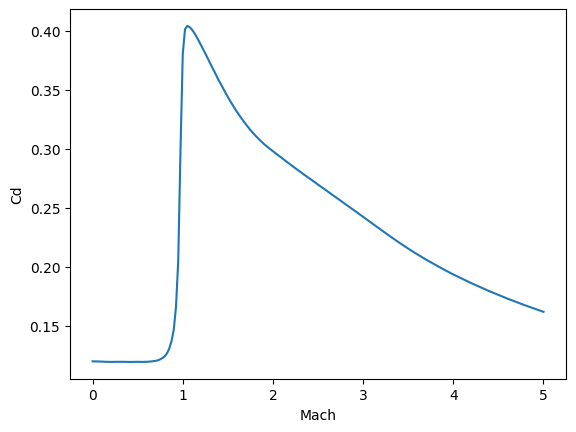

In [10]:
df = pandas.DataFrame(TableG7)
ax = df.plot(x='Mach', y='CD', ylabel='Cd', legend=False)
plt.show()

# Multiple-BC
In the old days, even a G7 projectile like the 168gr .308 OTM was quoted with a G1 BC.  Then Sierra offered a multiple-BC model.  Later, Litz published a multiple-BC G7 model.  Here's how they compare.

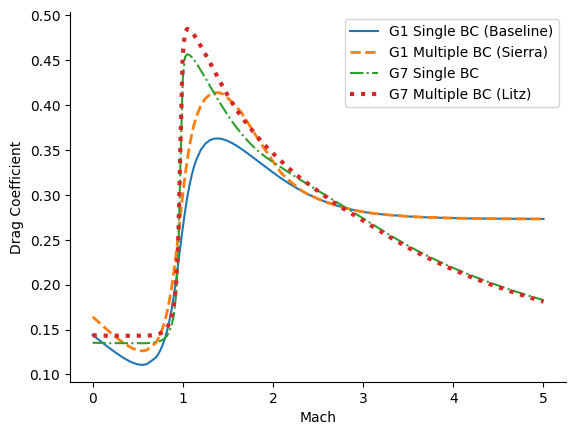

In [11]:
# Single G1 BC
dm1 = DragModelMultiBC([BCPoint(.462, Mach=1)], TableG1, weight=168, diameter=.308)
# Sierra's G1 BC: 0.462 above 2600 fps, 0.447 above 2100 fps, 0.424 above 1600 fps, and .405 below that.
dm2 = DragModelMultiBC([BCPoint(.462, V=Velocity.FPS(2600)), BCPoint(.462-(.462-.447)/2, V=Velocity.FPS(2350)), BCPoint(.424-(.424-.405)/2, V=Velocity.FPS(1850)), BCPoint(.405, V=Velocity.FPS(1600))],
                       TableG1, weight=168, diameter=.308)
# Single G7 BC
dm3 = DragModelMultiBC([BCPoint(.224, Mach=1)], TableG7, weight=168, diameter=.308)
# Litz's G7 multi-BC:
dm4 = DragModelMultiBC([BCPoint(.211, V=Velocity.FPS(1500)), BCPoint(.214, V=Velocity.FPS(2000)), BCPoint(.222, V=Velocity.FPS(2500)), BCPoint(.226, V=Velocity.FPS(3000))],
                       TableG7, weight=168, diameter=.308)
ax = pandas.DataFrame(dm1.drag_table).plot(x='Mach', y='CD', ylabel='Drag Coefficient', label='G1 Single BC (Baseline)')
pandas.DataFrame(dm2.drag_table).plot(x='Mach', y='CD', label='G1 Multiple BC (Sierra)', linestyle='dashed', linewidth=2, ax=ax)
pandas.DataFrame(dm3.drag_table).plot(x='Mach', y='CD', label='G7 Single BC', linestyle='dashdot', ax=ax)
pandas.DataFrame(dm4.drag_table).plot(x='Mach', y='CD', label='G7 Multiple BC (Litz)', linestyle='dotted', linewidth=3, ax=ax)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [12]:
PreferredUnits.distance = Unit.Yard
PreferredUnits.velocity = Unit.FPS
PreferredUnits.drop = Unit.Inch

for dm in [dm1, dm2, dm3, dm4]:
    zero = Shot(weapon=Weapon(sight_height=2), ammo=Ammo(dm, mv=Velocity.FPS(3000)))
    calc = Calculator()
    shot_result = calc.fire(zero, trajectory_range=1000, trajectory_step=500)
    display(shot_result.dataframe(True)[['distance', 'time', 'velocity', 'mach', 'target_drop', 'drag']].set_index('distance')[1:])

,time,velocity,mach,target_drop,drag
distance,,,,,
500.0 yd,0.606 s,2043.3 ft/s,1.83 mach,-63.5 inch,0.569
1000.0 yd,1.527 s,1317.7 ft/s,1.18 mach,-349.3 inch,0.376


,time,velocity,mach,target_drop,drag
distance,,,,,
500.0 yd,0.607 s,2027.7 ft/s,1.82 mach,-63.6 inch,0.610
1000.0 yd,1.562 s,1239.7 ft/s,1.11 mach,-358.0 inch,0.380


,time,velocity,mach,target_drop,drag
distance,,,,,
500.0 yd,0.611 s,2014.6 ft/s,1.80 mach,-64.1 inch,0.584
1000.0 yd,1.564 s,1227.8 ft/s,1.10 mach,-359.7 inch,0.459


,time,velocity,mach,target_drop,drag
distance,,,,,
500.0 yd,0.611 s,2001.9 ft/s,1.79 mach,-64.2 inch,0.609
1000.0 yd,1.587 s,1179.1 ft/s,1.06 mach,-365.6 inch,0.472


# Working With Units

In [13]:
initial_distance_unit = PreferredUnits.distance
PreferredUnits.distance = Unit.Foot
print(f'Default distance unit: {PreferredUnits.distance.name}')
# Can create value in default unit with either float or another unit of same type
print(f'\tInstantiated from float (5): {PreferredUnits.distance(5)}')
print(f'\tInstantiated from Distance.Line(200): {PreferredUnits.distance(Distance.Line(200))}')

# Ways to define value in units
# 1. old syntax
unit_in_meter = Distance(100, Distance.Meter)
# 2. short syntax by Unit type class
unit_in_meter = Distance.Meter(100)
# 3. by Unit enum class
unit_in_meter = Unit.Meter(100)
print(f'100 meters: {unit_in_meter}')
# >>> 100 meters: 100.0m

# Convert unit
# 1. by .convert()
unit_in_yards = unit_in_meter.convert(Distance.Yard)
# 2. using shift syntax
unit_in_yards = unit_in_meter << Distance.Yard  # '<<=' operator also supports
print(f'100 meters in {unit_in_yards.units.key}: {unit_in_yards}')
# >>> 100 meters in yard: 109.4yd

# Get value in specified units (as float)
# 1. by .get_in()
value_in_km = unit_in_yards.get_in(Distance.Kilometer)
# 2. by shift syntax
value_in_km = unit_in_yards >> Distance.Kilometer  # '>>=' operator also supports
print(f'100 meters, value in km: {value_in_km}  (value type is {type(value_in_km)})')
# >>> 100 meters, value in km: 0.1  (value type is <class 'float'>)

# Getting unit raw value (a float)
rvalue = Distance.Meter(100).raw_value
rvalue = float(Distance.Meter(100))
print(f'100 meters in raw value: {rvalue}  (raw type is {type(rvalue)})')
# >>> 100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)

# Comparison operators supported: < > <= >= == !=
print(f'Comparison: {unit_in_meter} == {Distance.Centimeter(100)}: {unit_in_meter == Distance.Centimeter(100)}')  # >>> False, compare two units by raw value
print(f'Comparison: {unit_in_meter} > .1*{unit_in_meter}: {unit_in_meter > .1*unit_in_meter.raw_value}')  # >>> True, compare unit with float by raw value

PreferredUnits.distance = initial_distance_unit  # Restore default unit
print(f'Restored default distance unit: {PreferredUnits.distance.name}')

Default distance unit: Foot
	Instantiated from float (5): 5.0ft
	Instantiated from Distance.Line(200): 1.67ft
100 meters: 100.0m
100 meters in yard: 109.4yd
100 meters, value in km: 0.1  (value type is <class 'float'>)
100 meters in raw value: 3937.0078740157483  (raw type is <class 'float'>)
Comparison: 109.4yd == 100.0cm: False
Comparison: 109.4yd > .1*109.4yd: True
Restored default distance unit: Yard
